# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Transfer learning

In the previous notebook we have trained our own CNN and we got a certain performance. Let's see how hard it is to match that performance with transfer learning.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly and check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [1]:
# Install requirements
!pip install -r requirements.txt --no-cache-dir --prefer-binary | grep -v "already satisfied"

In [2]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Create transfer learning architecture

Open the file `src/transfer.py` and complete the `get_model_transfer_learning` function. When you are done, execute this test:

In [4]:
!pytest -vv src/transfer.py

============================= test session starts ==============================
platform linux -- Python 3.8.20, pytest-7.1.1, pluggy-1.5.0 -- /home/sagemaker-user/.conda/envs/venv/bin/python3.8
cachedir: .pytest_cache
rootdir: /home/sagemaker-user/landmark-classifier
plugins: anyio-4.5.2
collected 1 item                                                               

src/transfer.py::test_get_model_transfer_learning PASSED                 [100%]

=============================== warnings summary ===============================
src/transfer.py::test_get_model_transfer_learning
src/transfer.py::test_get_model_transfer_learning
src/transfer.py::test_get_model_transfer_learning
src/transfer.py::test_get_model_transfer_learning
src/transfer.py::test_get_model_transfer_learning
  /home/sagemaker-user/.conda/envs/venv/lib/python3.8/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
    if LooseVersion(module.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Train, validation and test

Let's train our transfer learning model! Let's start defining the hyperparameters:

In [10]:
batch_size = 32  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 50  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 1e-5 # regularization. Increase this to combat overfitting

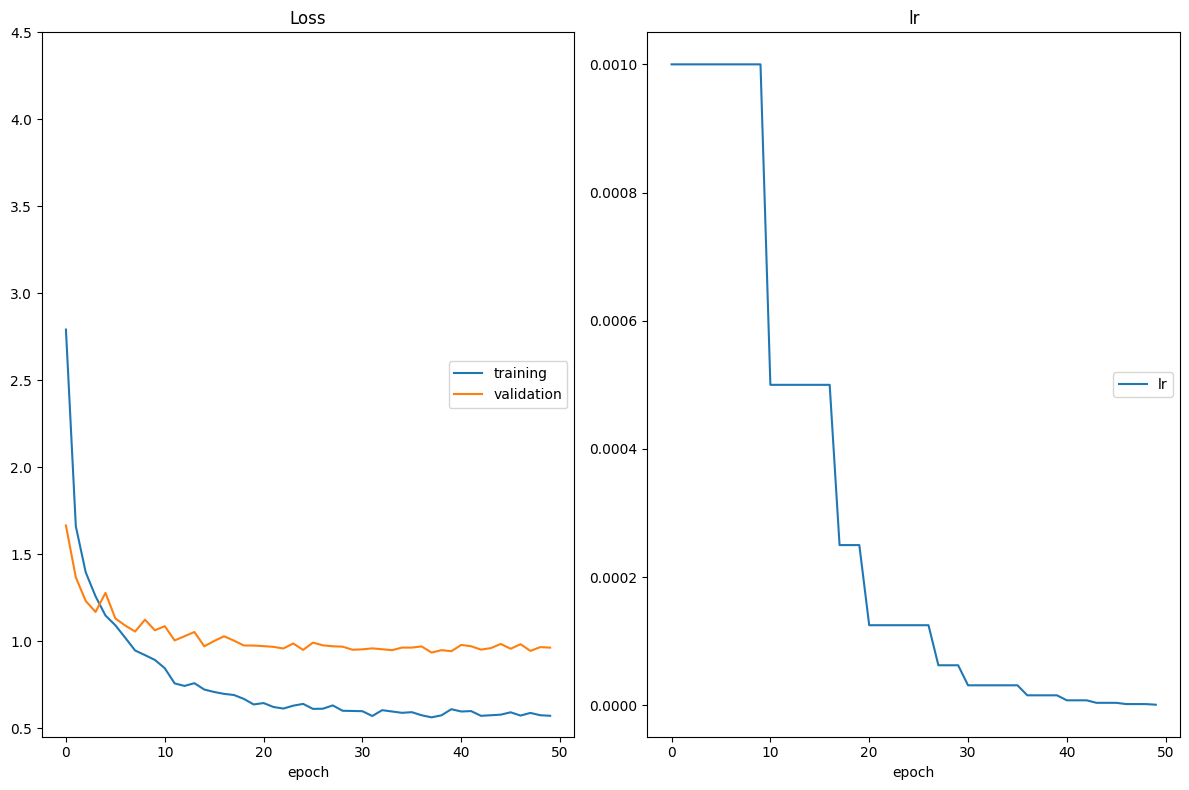

In [11]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the
# values
model_transfer = get_model_transfer_learning(model_name="resnet50", n_classes=num_classes) # YOUR CODE HERE

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True
)

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> __Question:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/>  __Answer:__ 

**I used transfer learning with a ResNet backbone rather than training a deep network from scratch because pretrained ImageNet weights give a large head-start: early layers already extract edges, textures and mid-level patterns that are highly relevant for landmarks. Steps I took and why:**

- Choose backbone: I selected ResNet (resnet50) for a a higher accuracy.

- Load pretrained weights: Initializing from ImageNet speeds convergence and improves generalization on limited labeled data.

- Freeze backbone (initially): I set param.requires_grad = False so only the new classifier head trains first. This prevents catastrophic forgetting and lets the head learn to map pretrained features to our 50 classes quickly.

- Replace classifier head: I replaced the model’s final linear layer with nn.Linear(num_ftrs, n_classes) sized to our problem. The new head can be regularized (dropout) and trained with a higher learning rate.

- Train head then (optionally) fine-tune: Typical strategy is to train just the head for several epochs (Adam, lr ≈ 1e-3) and only afterwards unfreeze the last residual block(s) and fine-tune the entire network with a smaller lr (e.g., 1e-4). This often improves top-1 accuracy.

- Data preprocessing & augmentation: I use RandomResizedCrop(224), RandomHorizontalFlip, small ColorJitter, and normalize by the dataset mean/std. This increases robustness to viewpoint and lighting changes without destroying landmark cues.

- Optimization & scheduling: Adam (or SGD with momentum) works well; I used a small weight decay (≈1e-4) and a ReduceLROnPlateau scheduler to drop lr when val loss plateaus.

- Validation & checkpointing: Save the best checkpoint by validation loss/accuracy, and monitor validation accuracy to avoid overfitting.

- Why this is suitable: transfer learning leverages general visual features learned on a huge dataset (ImageNet), which are highly relevant for landmark recognition. Freezing the backbone reduces overfitting risk and training time, while a replaced head provides the task-specific discriminative mapping required for 50 classes. Progressive unfreezing (head → some layers → whole net) gives the best tradeoff between stability and final accuracy.

Now play with the hyperparameters and see which performance you can get on the validation set. You should get at least 60% for a passing grade, but a good model choice and a good training strategy could get you up to 80% or so. Let's see how close you can get!

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60% and matches more or less what you got on the validation set (otherwise you're overfitting!)

In [13]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("resnet50", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer.pt'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 40/40 [00:13<00:00,  2.86it/s]

Test Loss: 0.847653


Test Accuracy: 78% (985/1250)


0.8476531239692121

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Export using torchscript

Now, just like we did with our original model, we export the best fit model using torchscript so that it can be used in our application:

In [14]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


100%|███████████████████████████████████████| 1250/1250 [01:36<00:00, 12.96it/s]


Accuracy: 0.7824


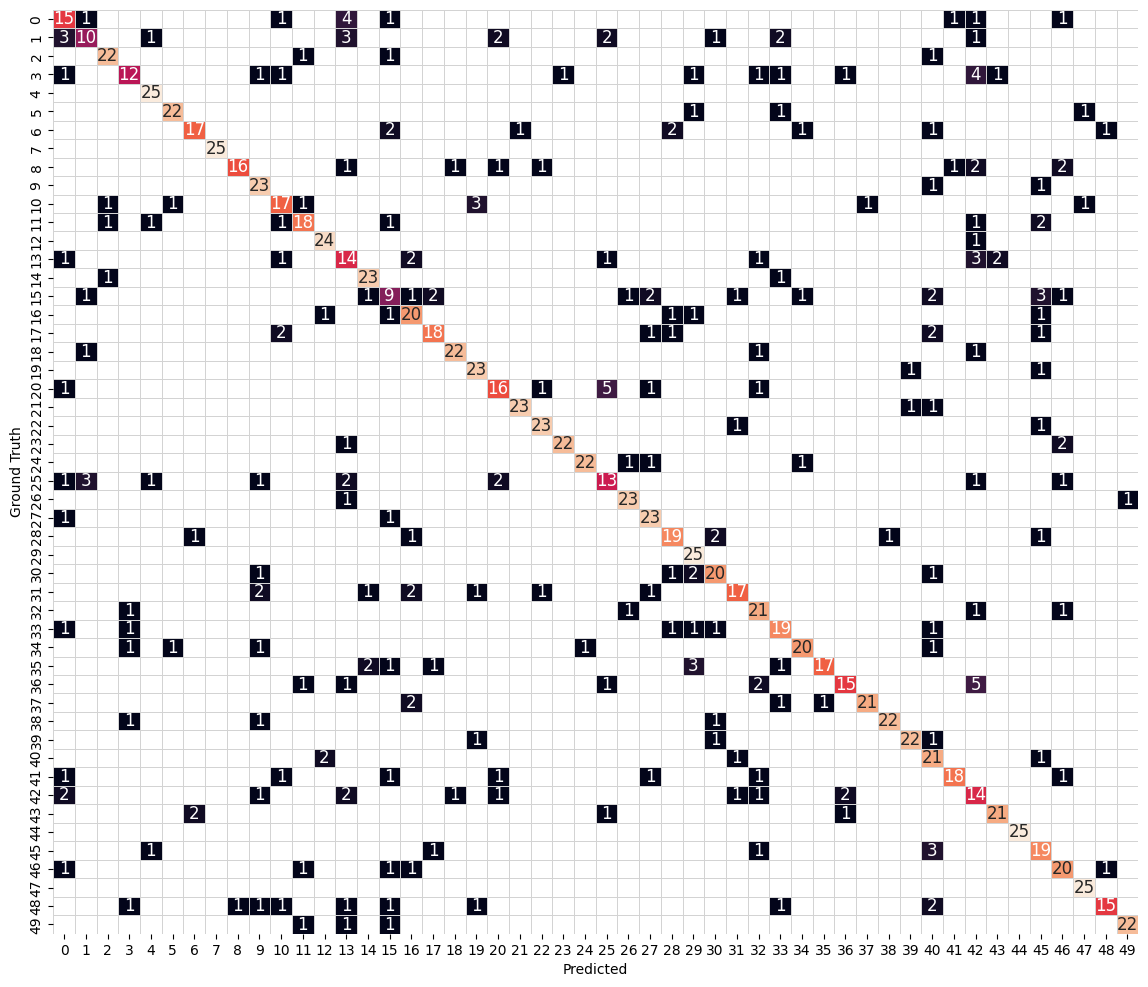

In [15]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)